In [1]:
import sys
import os
sys.path.append("../")

In [2]:

import warnings
warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from IPython.display import clear_output
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import numpy as np

from oodeel.eval.metrics import bench_metrics
from oodeel.eval.plots import plot_ood_scores, plot_roc_curve, plot_2D_features
from oodeel.datasets import OODDataset
from oodeel.utils.torch_training_tools import train_torch_model
from methods import Dknn, Vim, energy, entropy, mahalanobis, Mls, Odin, Gram, kmeans, pca_knn, pca_mahalanobis, nmf_knn, nmf_mahalanobis
from data_preprocessing import get_test_dataset_cifar10, get_test_dataset_svhn, get_train_dataset_cifar10
from models import load_pretrained_weights_32


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

the length of the CIFAR-10 Training dataset :  50000
the length of the CIFAR-10 Test dataset :  10000
the length of the CIFARO-100 Training dataset :  50000
the length of the CIFAR-100 Test dataset :  10000
the length of the iNaturalist Test dataset :  10000
the length of the Places365 dataset :  36500
the length of the SVHN Test dataset :  26032
the length of the Texture Test dataset :  5640
the length of the Tiny Test dataset :  10000


In [3]:
torch.cuda.is_available()

True

In [4]:
# initilize data loaders
ds_train = get_train_dataset_cifar10()
ds_in = get_test_dataset_cifar10()
ds_out = get_test_dataset_svhn()


the length of the CIFAR-10 Training dataset :  50000
the length of the CIFAR-10 Test dataset :  10000
the length of the SVHN Test dataset :  26032


In [5]:
# initilize the pretrained model
model = load_pretrained_weights_32(dataset='CIFAR-10', model_version='s0')
model.to(device)
print(model)

checkpoint_path :  ../../models/CIFAR-10/cifar10_resnet18_32x32_base_e100_lr0.1_default/s0/best.ckpt
Model pretrained weight have been successfully loaded !


ResNet18_32(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, af

Test accuracy:	0.907800

=== Penultimate features viz ===


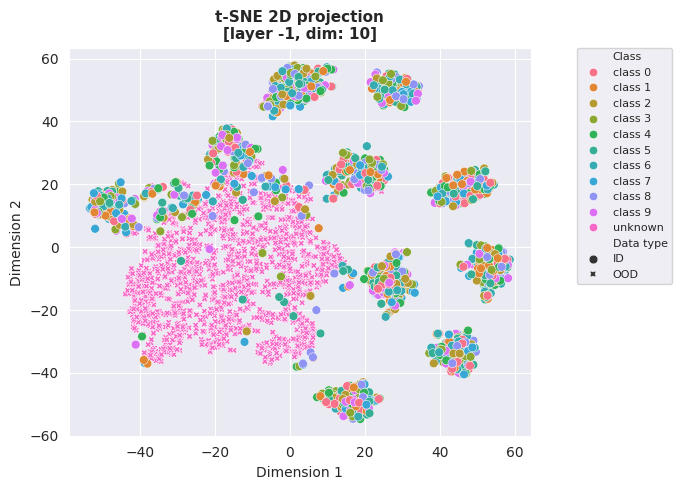

In [6]:
# evaluating thee model on test data to see test accuracy
model.eval()
labels, preds = [], []
for x, y in ds_in:
    x = x.to(device)
    # y = y.to(device)
    preds.append(torch.argmax(model(x), dim=-1).detach().cpu())
    labels.append(y)
print(f"Test accuracy:\t{accuracy_score(torch.cat(labels), torch.cat(preds)):.6f}")

# penultimate features 2d visualization
print("\n=== Penultimate features viz ===")
plt.figure(figsize=(7, 5))
plot_2D_features(
    model=model,
    in_dataset=ds_in,
    out_dataset=ds_out,
    output_layer_id=-1,
)
plt.tight_layout()
plt.show()

In [7]:
model.to(device)

ResNet18_32(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, af

# GRAM Method

=== Metrics ===
auroc      0.582863
fpr95tpr   0.938100

=== Plots ===


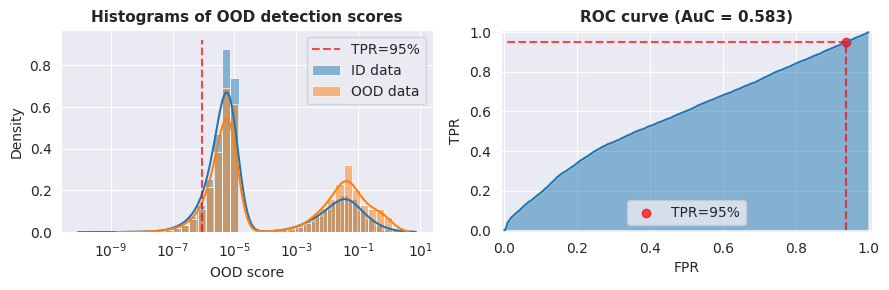

In [8]:
model.to("cpu")
for x , y in ds_in:
    x = x.to("cpu")
    y = y.to("cpu")

for x , y in ds_out:
    x = x.to("cpu")
    y = y.to("cpu")

for x , y in ds_train:
    x = x.to("cpu")
    y = y.to("cpu")
Gram.fit(model, ds_train, feature_layers_id=["fc"])
scores_in, _ = Gram.score(ds_in)
scores_out, _ = Gram.score(ds_out)


# Since many scores are equal to 0, we add a random noise to avoid bugs
# in Auroc and TPR computation.
scores_in += np.random.random_sample(size=scores_in.shape) * 10e-6
scores_out += np.random.random_sample(size=scores_out.shape) * 10e-6

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")


print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=True)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

model.to("cuda")
for x , y in ds_in:
    x = x.to("cuda")
    y = y.to("cuda")

for x , y in ds_out:
    x = x.to("cuda")
    y = y.to("cuda")

for x , y in ds_train:
    x = x.to("cuda")
    y = y.to("cuda")


# MLS Method

=== Metrics ===
auroc      0.871423
fpr95tpr   0.298900

=== Plots ===


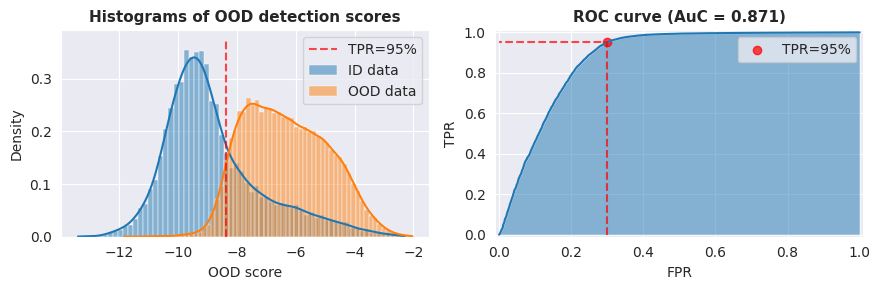

In [9]:
# === mls scores ===
Mls.fit(model)
scores_in, _ = Mls.score(ds_in)
scores_out, _ = Mls.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

# ODIN Method

=== Metrics ===
auroc      0.758292
fpr95tpr   0.681800

=== Plots ===


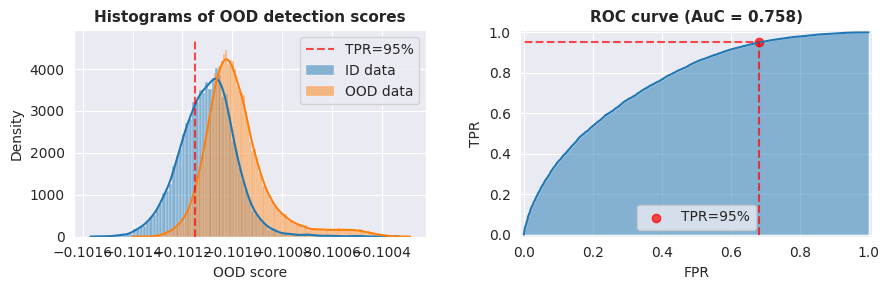

In [10]:
# === odin scores ===

Odin.fit(model)
scores_in, _ = Odin.score(ds_in)
scores_out, _ = Odin.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

# DKNN Method

=== Metrics ===
auroc      0.839994
fpr95tpr   0.318600

=== Plots ===


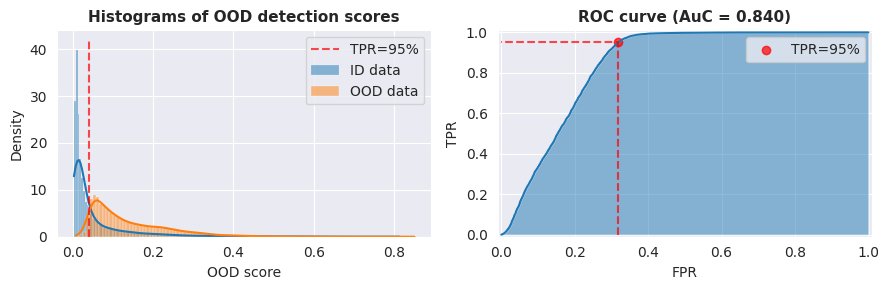

In [11]:
# === dknn scores ===
Dknn.fit(model, feature_layers_id=[-1], fit_dataset=ds_train)
scores_in, _ = Dknn.score(ds_in)
scores_out, _ = Dknn.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

# VIM Method

=== Metrics ===
auroc      0.734864
fpr95tpr   0.484900

=== Plots ===


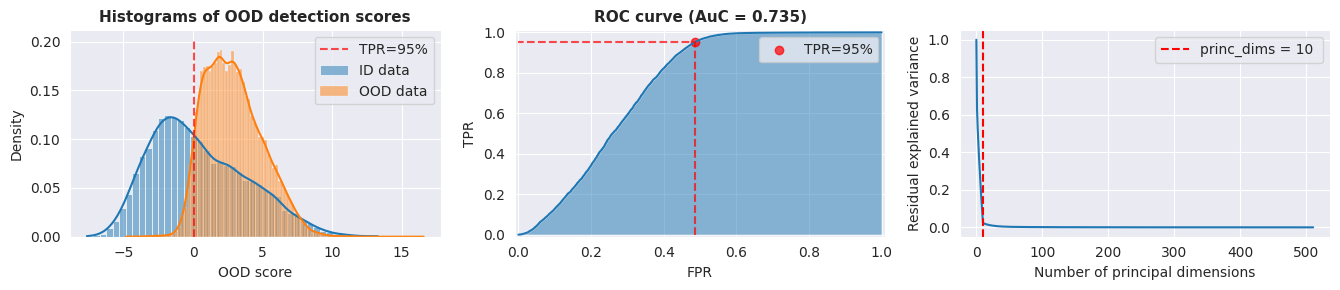

In [12]:
# === vim scores ===
Vim.fit(model, feature_layers_id=[-2], fit_dataset=ds_train)
scores_in, _ = Vim.score(ds_in)
scores_out, _ = Vim.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(13.5, 3))
plt.subplot(131)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(132)
plot_roc_curve(scores_in, scores_out)
plt.subplot(133)
Vim.plot_spectrum()
plt.tight_layout()
plt.show()

# Energy Method

=== Metrics ===
auroc      0.873560
fpr95tpr   0.295100

=== Plots ===


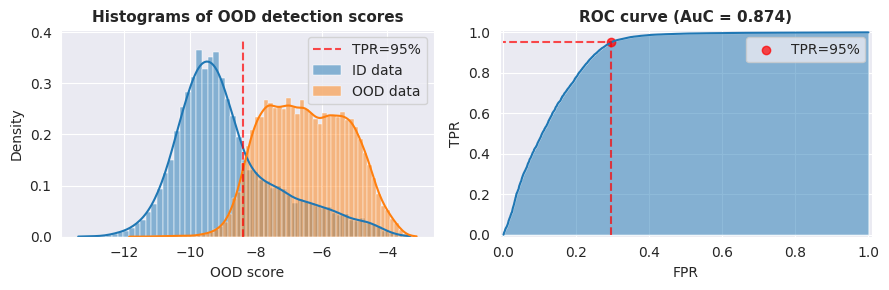

In [13]:
# === energy scores ===
energy.fit(model)
scores_in, _ = energy.score(ds_in)
scores_out, _ = energy.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

# Entropy Method

=== Metrics ===
auroc      0.838532
fpr95tpr   0.316600

=== Plots ===


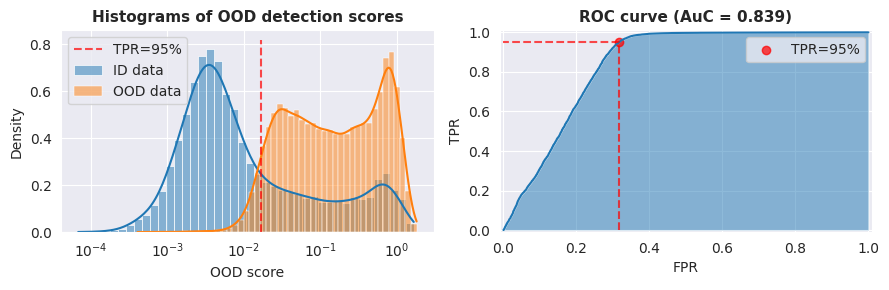

In [14]:
# === Entropy scores ===
entropy.fit(model)
scores_in, _ = entropy.score(ds_in)
scores_out, _ = entropy.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=True)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

# Mahalanobis Method

=== Metrics ===
auroc      0.872129
fpr95tpr   0.288500

=== Plots ===


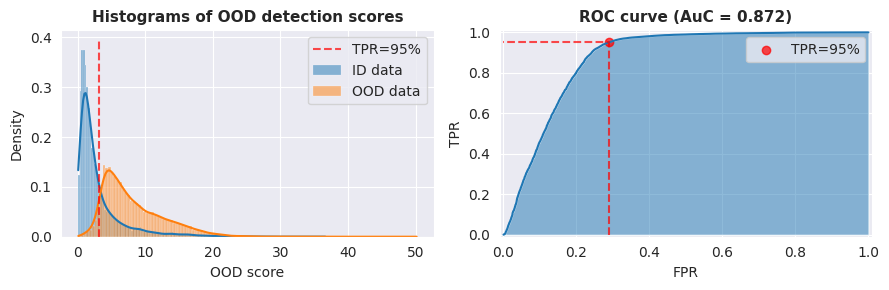

In [15]:
# === mahalanobis scores ===
mahalanobis.fit(model, feature_layers_id=[-1], fit_dataset=ds_train)
scores_in, _ = mahalanobis.score(ds_in)
scores_out, _ = mahalanobis.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

# K-MEANS Method

Performing K-means clustering...
K-means clustering Done...
#------------------------------------------------------------
=== Metrics ===
auroc      0.814572
fpr95tpr   0.406600

=== Plots ===


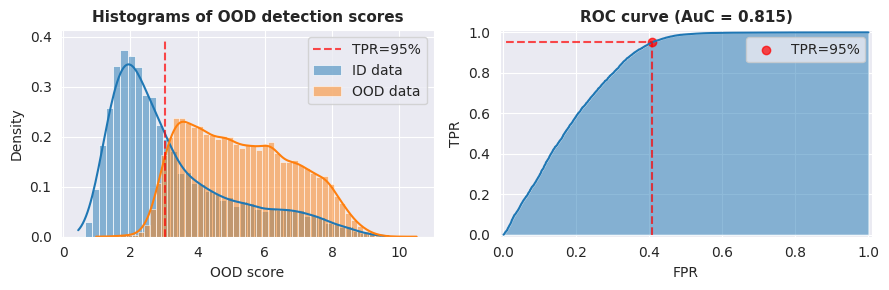

In [16]:
kmeans.fit(model, feature_layers_id=[-1], fit_dataset=ds_train)

scores_in, _ = kmeans.score(ds_in)
scores_out, _ = kmeans.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

# PCA - K-nearest-Neighbor

the shape of W_train is  :  (50000, 9)
the shape of H_base is  :  (9, 10)
=== Metrics ===
auroc      0.850353
fpr95tpr   0.343000

=== Plots ===


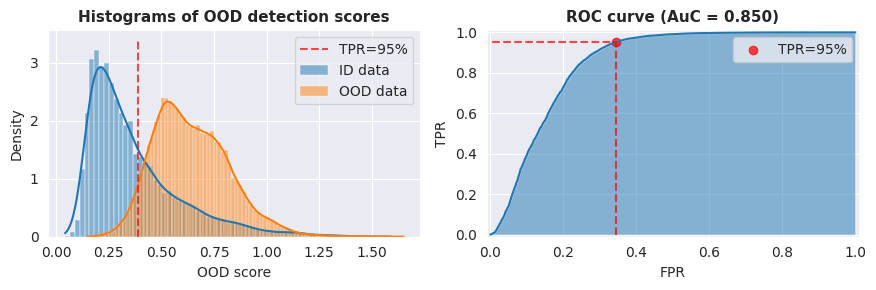

In [17]:
pca_knn.fit(model, feature_layers_id=[-1], fit_dataset=ds_train)

scores_in, _ = pca_knn.score(ds_in)
scores_out, _ = pca_knn.score(ds_out)


# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

# PCA - Mahalanobis Method

In [7]:
model.to("cpu")
for x , y in ds_in:
    x = x.to("cpu")
    y = y.to("cpu")

for x , y in ds_out:
    x = x.to("cpu")
    y = y.to("cpu")

for x , y in ds_train:
    x = x.to("cpu")
    y = y.to("cpu")

pca_mahalanobis.fit(model, feature_layers_id=[-1], fit_dataset=ds_train)

print("done fitting .......")

scores_in, _ = pca_mahalanobis.score(ds_in)
print("done score_in .......")
scores_out, _ = pca_mahalanobis.score(ds_out)

scores_in = np.negative(scores_in)
scores_out = np.negative(scores_out)
# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

model.to("cuda")
for x , y in ds_in:
    x = x.to("cuda")
    y = y.to("cuda")

for x , y in ds_out:
    x = x.to("cuda")
    y = y.to("cuda")

for x , y in ds_train:
    x = x.to("cuda")
    y = y.to("cuda")

the shape of W_train is  :  (50000, 9)
the shape of H_base is  :  (9, 10)
done fitting .......


KeyboardInterrupt: 

# NMF - K-nearest-neghbor Method

the shape of H_base is :  (9, 10)
the shape of W_train is  :  (50000, 9)
done fitting .......
done score_in .......
=== Metrics ===
auroc      0.778483
fpr95tpr   0.647000

=== Plots ===


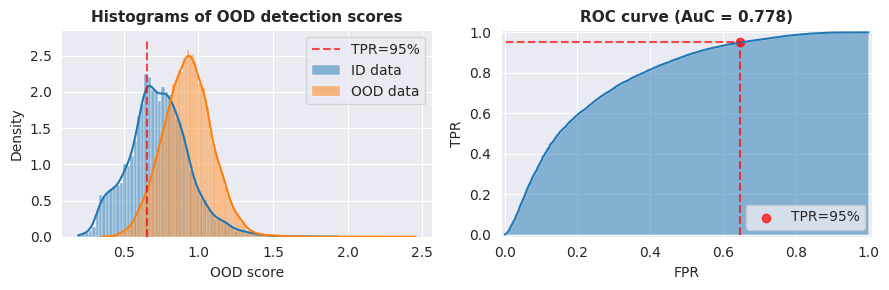

In [8]:
model.to("cuda")
for x , y in ds_in:
    x = x.to("cuda")
    y = y.to("cuda")

for x , y in ds_out:
    x = x.to("cuda")
    y = y.to("cuda")

for x , y in ds_train:
    x = x.to("cuda")
    y = y.to("cuda")
    
nmf_knn.fit(model, feature_layers_id=[-1], fit_dataset=ds_train)
print("done fitting .......")

scores_in, _ = nmf_knn.score(ds_in)
print("done score_in .......")

scores_out, _ = nmf_knn.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

# NMF - Mahalanobis Method

the shape of H_base is :  (8, 10)
the shape of W_train is  :  (50000, 8)
=== Metrics ===
auroc      0.683044
fpr95tpr   0.828900

=== Plots ===


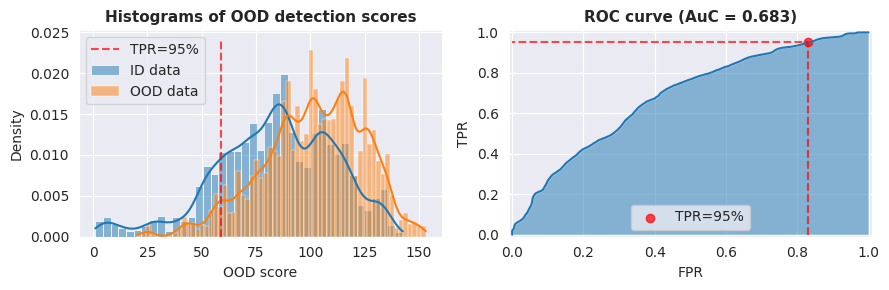

In [31]:
model.to("cpu")
for x , y in ds_in:
    x = x.to("cpu")
    y = y.to("cpu")

for x , y in ds_out:
    x = x.to("cpu")
    y = y.to("cpu")

for x , y in ds_train:
    x = x.to("cpu")
    y = y.to("cpu")

nmf_mahalanobis.fit(model, feature_layers_id=[-1], fit_dataset=ds_train)

scores_in, _ = nmf_mahalanobis.score(ds_in)
scores_out, _ = nmf_mahalanobis.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
print("=== Metrics ===")
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

print("\n=== Plots ===")
# hists / roc
plt.figure(figsize=(9, 3))
plt.subplot(121)
plot_ood_scores(scores_in, scores_out, log_scale=False)
plt.subplot(122)
plot_roc_curve(scores_in, scores_out)
plt.tight_layout()
plt.show()

model.to("cuda")
for x , y in ds_in:
    x = x.to("cuda")
    y = y.to("cuda")

for x , y in ds_out:
    x = x.to("cuda")
    y = y.to("cuda")

for x , y in ds_train:
    x = x.to("cuda")
    y = y.to("cuda")